In [ ]:
# !rm -r sample_data .config
# !git clone https://github.com/saveliybabin/VRP-solver .

In [242]:
import requests
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
import networkx as nx
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
import pandas as pd
from train import train_epoch_sl
from nets.nar_model_vrp import NARModel
from nets.encoders.gnn_encoder import GNNEncoder
from utils import torch_load_cpu, load_problem
import warnings
warnings.filterwarnings('ignore')

In [46]:
#!g1.1
%pip install pickle5
import pickle5 as pickle

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [47]:
#!g1.1
%pip install ortools

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [251]:
#!g1.1
problem = load_problem('cvrp')

In [249]:
import pickle
with open('data/train_cvrp_v3_12800.pkl', 'rb') as f:
    train_dataset = pickle.load(f)
with open('data/val_cvrp_v5_1000.pkl', 'rb') as f:
    val_dataset = pickle.load(f)    
    

In [7]:
# train_dataset = problem.make_dataset(
#         'data/vrp/dataset_test.pkl', size=21, num_samples=12800
#     )


In [8]:
# import pickle
# def save_object(obj, filename):
#     with open(filename, 'wb') as outp:  # Overwrites any existing file.
#         pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

# # sample usage
# save_object(train_dataset, 'train_cvrp_v3_12800.pkl')

In [9]:
# val_dataset = problem.make_dataset(
#         'data/vrp/dataset_test_2.pkl', size=21, num_samples=1000
#     )

In [10]:
# save_object(val_dataset, 'val_cvrp_v5_1000.pkl')

In [50]:
train_example = train_dataset[1]
train_example['demand'].shape

torch.Size([20])

In [51]:
def edges(adj):

    for i, neighbors in enumerate(adj):
        for j, v in enumerate(neighbors):
            if v:
                yield (i, j)

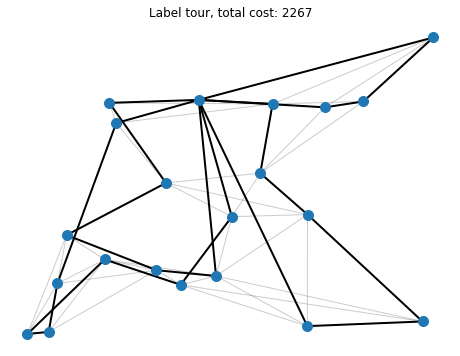

In [52]:
all_loc = np.concatenate((np.array(train_example['depot']).reshape(1, -1), np.array(train_example['loc'])), 0)
dist_matrix = squareform(pdist(all_loc))
G = nx.from_numpy_array(1-train_example['graph'].numpy())
G.remove_edges_from(nx.selfloop_edges(G))
pos = {i: coord for i, coord in enumerate(all_loc)}
# tour = train_example['tour_edges'].nonzero().numpy()
tour = [i for i in edges(train_example['adj'])]
plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos=pos, node_size=100)
nx.draw_networkx_edges(G, pos=pos, alpha=0.2)
nx.draw_networkx_edges(G, pos=pos, width=2, edgelist=tour, )
cost = train_example['total_dist']
plt.title(f'Label tour, total cost: {cost:.0f}')
plt.axis('off')
plt.show()

In [253]:
#!g1.1
from nets.attention_model import AttentionModel
# model = NARModel(
#     problem=load_problem('cvrp'),
#     embedding_dim=100,
#     encoder_class=GNNEncoder,
#     n_encode_layers=4,
#     aggregation='max',
#     aggregation_graph='mean',
#     normalization='batch',
#     beam_size = 1
# )
model = AttentionModel(
    problem=load_problem('cvrp'),
    embedding_dim=100,
    encoder_class=GNNEncoder,
    n_encode_layers=2,
    aggregation='max',
    aggregation_graph='mean',
    normalization='batch',
    n_heads = 4, 
)
# model = pickle.load(open('/content/trained_models/vrp_solver1.sav', 'rb'))
model.to('cuda')

AttentionModel(
  (init_embed_depot): Linear(in_features=2, out_features=100, bias=True)
  (init_embed): Linear(in_features=3, out_features=100, bias=True)
  (embedder): GNNEncoder(
    (init_embed_edges): Embedding(3, 100)
    (layers): ModuleList(
      (0): GNNLayer(
        (U): Linear(in_features=100, out_features=100, bias=True)
        (V): Linear(in_features=100, out_features=100, bias=True)
        (A): Linear(in_features=100, out_features=100, bias=True)
        (B): Linear(in_features=100, out_features=100, bias=True)
        (C): Linear(in_features=100, out_features=100, bias=True)
        (norm_h): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (norm_e): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      )
      (1): GNNLayer(
        (U): Linear(in_features=100, out_features=100, bias=True)
        (V): Linear(in_features=100, out_features=100, bias=True)
        (A): Linear(in_features=100, o

In [254]:
#!g1.1
optimizer = optim.Adam(params=model.parameters(), lr=0.0005)

In [255]:
#!g1.1
import warnings
warnings.filterwarnings("ignore")

class option():
    def __init__(self):
        self.run_name = 'train'
        self.epoch_size = 10000
        self.batch_size = 100
        self.no_tensorboard = True
        self.num_workers = 0
        self.no_progress_bar = False
        self.device = 'cuda'
        self.model = 'ar'
        self.accumulation_steps = 8
        self.max_grad_norm = 1
        self.log_step = 100
        self.checkpoint_epochs = 0
        self.n_epochs = 5
opt = option()

for epoch in range(opt.n_epochs):
    train_epoch_sl(
        model,
        optimizer,
        optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 1.0 ** epoch),
        epoch,
        train_dataset,
        [val_dataset],
        problem,
        None,
        opt
    )


Start train epoch 0, lr=0.0005 for run train

epoch: 0, train_batch_id: 0, loss: 138461616.0, avg_cost: 6.550836563110352
grad_norm: 9.659507751464844, clipped: 1
Finished epoch 0, took 00:00:13 s


AssertionError: Logprobs should not be -inf, check sampling procedure!


100%|##########| 100/100 [00:13<00:00,  7.54it/s]

  0%|          | 0/10 [02:33<?, ?it/s]


In [227]:
#!g1.1
import pickle
with open('model_NAR_30ep_1beam_4enc.sav', 'rb') as f:
    model = pickle.load(f)

In [123]:
#!g1.1
# filename = 'model_NAR_30ep_1beam_4enc.sav'
# pickle.dump(model, open(filename, 'wb'))

In [218]:
#!g1.1
cvrplib = False

In [220]:
#!g1.1
if cvrplib:
  from generator.parse_cvrplib import get_instance_from_CVRPLIB
  from problems.vrp.problem_vrp import nearest_neighbor_graph

  car_num = 7
  test_df, test_tour, test_paths  = get_instance_from_CVRPLIB("A", "A-n53-k7")
  test_df['demand_norm'] = test_df['demand']/test_df['cap']
  test_df['latitude_norm'] = test_df['latitude']/100
  test_df['longitude_norm'] = test_df['longitude']/100
  x = torch.tensor(test_df[['latitude_norm', 'longitude_norm', 'demand_norm']].values).type(torch.float)
  graph = torch.ByteTensor(nearest_neighbor_graph(x, neighbors = 0.2, knn_strat = 'percentage')).to('cuda') 

else:
  car_num = 5
  test_example = val_dataset[49]
  with torch.no_grad():
    add_depot_demand = torch.cat((torch.zeros(1), test_example['demand']), 0)
    add_depot_loc = torch.cat((test_example['depot'][None, :], test_example['loc']), 0)
    x = torch.cat((add_depot_loc, add_depot_demand[:, None]), 1)
    graph = test_example['graph'].to('cuda')

In [221]:
#!g1.1
dist_matrix = squareform(pdist(x[:, :2].numpy()))
dist_matrix[(range(dist_matrix.shape[0])), (range(dist_matrix.shape[0]))] = np.inf

Make GNN prediction

In [228]:
#!g1.1
nodes = x[None, ...].to('cuda')
graph_ = graph[None, ...].to('cuda')
model.eval()
with torch.no_grad():
    embeddings = model.embedder(model._init_embed(nodes), graph_)
embeddings.shape

/home/jupyter/work/resources/VRP-solver/nets/encoders/gnn_encoder.py:118: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:20.)
  Vh[graph.unsqueeze(-1).expand_as(Vh)] = 0
/home/jupyter/work/resources/VRP-solver/nets/encoders/gnn_encoder.py:118: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:20.)
  Vh[graph.unsqueeze(-1).expand_as(Vh)] = 0
/home/jupyter/work/resources/VRP-solver/nets/encoders/gnn_encoder.py:118: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:20.)
  Vh[graph.unsqueeze(-1).expand_as(Vh)] = 0
/home/jupyter/work/resources/VRP-solver/nets/encoders/gnn_encoder.py:118: UserWarning: indexing with dtype

torch.Size([1, 21, 100])

In [229]:
#!g1.1
with torch.no_grad():
    Ux = model.project_node_emb(embeddings)
    Gx = model.project_graph_emb(embeddings.mean(dim=1))
edge_embeddings = F.relu(Ux[:, :, None, :] + Ux[:, None, :, :] + Gx[:, None, None, :])

if model.mask_graph:
    edge_embeddings[graph[:, :, :, None].expand_as(edge_embeddings)] = 0

# Compute logits
with torch.no_grad():
    logits = model.edge_pred(edge_embeddings)  # B x V x V x 2
proba = F.softmax(logits, dim=3)
proba_adj = proba[0, :, :, 1].cpu().numpy()
proba_adj.shape

(21, 21)

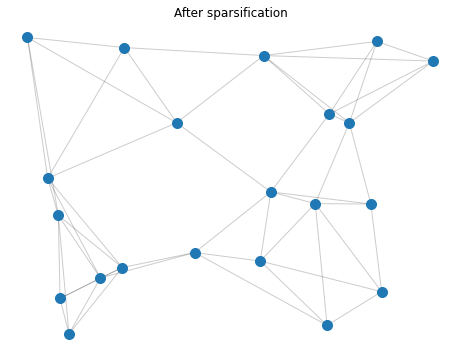

In [230]:
#!g1.1
# G = nx.from_numpy_array(1-test_example['graph'].numpy())
G = nx.from_numpy_array(1-graph.cpu().numpy())
G.remove_edges_from(nx.selfloop_edges(G))
pos = {i: coord.numpy() for i, coord in enumerate(x[:, :2])}
plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos=pos, node_size=100)
nx.draw_networkx_edges(G, pos=pos, alpha=0.2)
plt.title('After sparsification')
plt.axis('off')
plt.show()

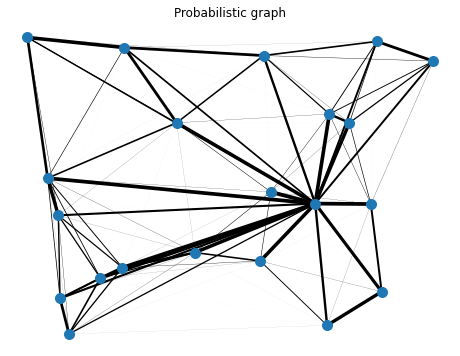

In [231]:
#!g1.1
G = nx.from_numpy_array(proba_adj)
G.remove_edges_from(nx.selfloop_edges(G))
pos = {i: coord.numpy() for i, coord in enumerate(x[:, :2])}
plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos=pos, node_size=100)
nx.draw_networkx_edges(G, pos=pos, width=[(G[u][v]['weight']*2)**2 for u,v in G.edges])
plt.title('Probabilistic graph')
plt.axis('off')
plt.show()

GNN model

In [232]:
#!g1.1
def array_separator(arr):
  out = []
  out_temp = [0]
  for i in arr[1:]:
    if i == 0:
      if len(out_temp) != 1:
        out_temp.append(0)
        out.append(np.array(out_temp))
      out_temp = [0]
    else:
      out_temp.append(i)
  return np.array(out)

In [233]:
#!g1.1
with torch.no_grad():
    _, _, tour = model.forward(nodes, graph[None, :], car_num, return_pi=True)
tour = tour.cpu().numpy()[0]
tour = np.append(tour, tour[0])

/home/jupyter/work/resources/VRP-solver/nets/encoders/gnn_encoder.py:118: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:20.)
  Vh[graph.unsqueeze(-1).expand_as(Vh)] = 0
/home/jupyter/work/resources/VRP-solver/nets/encoders/gnn_encoder.py:118: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:20.)
  Vh[graph.unsqueeze(-1).expand_as(Vh)] = 0
/home/jupyter/work/resources/VRP-solver/nets/encoders/gnn_encoder.py:118: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:20.)
  Vh[graph.unsqueeze(-1).expand_as(Vh)] = 0
/home/jupyter/work/resources/VRP-solver/nets/encoders/gnn_encoder.py:118: UserWarning: indexing with dtype

/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from typing import Optional, Dict, Set, Iterator, Callable, cast


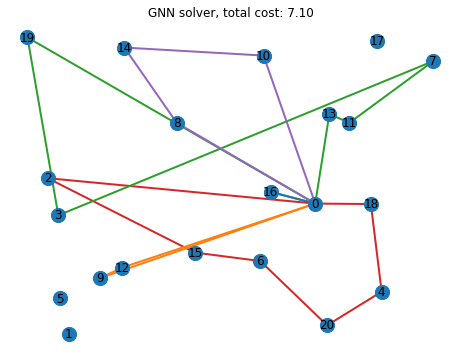

In [235]:
#!g1.1
# G = nx.from_numpy_array(1-test_example['graph'].numpy())
G = nx.from_numpy_array(1-graph.cpu().numpy())
G.remove_edges_from(nx.selfloop_edges(G))
plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos=pos, node_size=200)
# nx.draw_networkx_edges(G, pos=pos, alpha=0.2)
subtours = array_separator(tour)
colors = ["tab:blue", "tab:red", "tab:green", "tab:purple", "tab:orange", "tab:olive", "black", "tab:blue", "tab:red", "tab:green", "tab:purple", "tab:orange", "tab:olive", "black"]
for n, sub_t in enumerate(subtours):
    nx.draw_networkx_edges(G, pos=pos, width=2, edgelist=np.stack([sub_t[:-1], sub_t[1:]], axis=1).tolist(), edge_color = colors[n])
nx.draw_networkx_labels(G, pos)
dist_matrix_ = dist_matrix.copy()
dist_matrix_[(range(dist_matrix_.shape[0])), (range(dist_matrix_.shape[0]))] = 0
cost = dist_matrix_[tour[:-1], tour[1:]].sum()
plt.title(f'GNN solver, total cost: {cost:.2f}')
plt.axis('off')
plt.show()


In [236]:
#!g1.1
if cvrplib:
  temp = {i: 0 for i in range(test_df['cars'].max())}
  car = 0
  for i in tour[1:].astype(int):
      if i == 0:
          car+=1
      else:
          temp[car] += test_df['demand'][i]/test_df['cap'].max()
else:
  temp = {i: 0 for i in range(car_num)}
  car = 0
  for i in tour[1:].astype(int):
      if i == 0:
          car+=1
      else:
          temp[car] += test_example['demand'][i-1]
temp

KeyError: 5

OR-Tools

In [237]:
#!g1.1
if cvrplib:
  from heurictics.op_tools import *
  from generator.distance_matrix import distance_function
  customer_count = 52

  distance = distance_function(test_df[['latitude', 'longitude']].values, is_coord = False)
  dist_matrix =pd.DataFrame(distance)
  dist_matrix.iloc[range(customer_count), range(customer_count)] = 0

  op_results = main(test_df, distance, cars = test_df['cars'].max(), cap = test_df['cap'].max())
  tour_sublist = np.array(list(op_results['paths'].values()))
  rtour = np.array([item for sublist in tour_sublist for item in sublist])
else:
  rtour = test_example['tour_nodes'].numpy()

/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from typing import Optional, Dict, Set, Iterator, Callable, cast


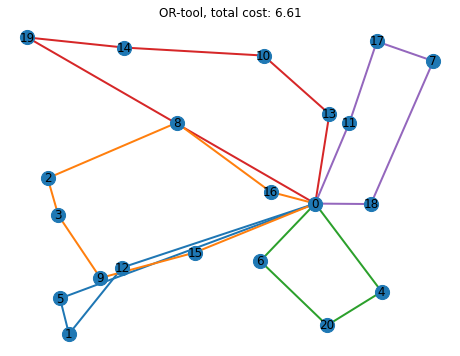

In [238]:
#!g1.1
plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos=pos, node_size=200)
# nx.draw_networkx_edges(G, pos=pos, alpha=0.2)
subtours = array_separator(rtour)
colors = ["tab:blue", "tab:red", "tab:green", "tab:purple", "tab:orange", "tab:olive", "black", "tab:blue", "tab:red", "tab:green", "tab:purple", "tab:orange", "tab:olive", "black"]
for n, sub_t in enumerate(subtours):
  nx.draw_networkx_edges(G, pos=pos, width=2, edgelist=np.stack([sub_t[:-1], sub_t[1:]], axis=1).tolist(), edge_color = colors[n])
nx.draw_networkx_labels(G,pos)
cost = dist_matrix_[rtour[:-1].astype(int), rtour[1:].astype(int)].sum()
plt.title(f'OR-tool, total cost: {cost:.2f}')
plt.axis('off')
plt.show()

In [239]:
if cvrplib:
  temp = {i: 0 for i in range(test_df['cars'].max())}
  car = 0
  for i in rtour[1:].astype(int):
      if i == 0:
          car+=1/2
      else:
          temp[car] += test_df['demand'][i]/test_df['cap'].max()
else:
  temp = {i: 0 for i in range(car_num)}
  car = 0
  for i in rtour[1:].astype(int):
      if i == 0:
          car+=1
      else:
          temp[car] += test_example['demand'][i-1]
temp

{0: tensor(0.8667),
 1: tensor(0.8667),
 2: tensor(0.5000),
 3: tensor(1.),
 4: tensor(0.9667)}

Greedy solution

In [240]:
if not cvrplib:
  test_df_ = pd.DataFrame(torch.cat((test_example['depot'][None, : ], test_example['loc']), 0).numpy(), columns = ['latitude', 'longitude'])
  test_df_['demand'] = torch.cat((torch.zeros(1), test_example['demand']), 0).numpy()
  test_df_['cap'] = 1
  df_gr = test_df_.copy()
else:
  df_gr = test_df.copy()

In [241]:
from generator.distance_matrix import distance_function
customer_count = 52

distance = distance_function(df_gr[['latitude', 'longitude']].values, is_coord = False)
dist_matrix =pd.DataFrame(distance)
dist_matrix.iloc[range(customer_count), range(customer_count)] = np.inf

IndexError: positional indexers are out-of-bounds

In [ ]:
from heurictics.greedy import greedy_heurictics

greedy_results = greedy_heurictics(df_gr, dist_matrix, dim = customer_count, cap = df_gr['cap'].max(), k_nei = 3, iters = 100)

In [ ]:
gr_tour = []
for p in greedy_results['paths'].values():
  for node in p: 
    gr_tour.append(node)

In [ ]:
gr_tour = np.array(gr_tour)
plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos=pos, node_size=200)
# nx.draw_networkx_edges(G, pos=pos, alpha=0.2)
subtours = array_separator(gr_tour)
colors = ["tab:blue", "tab:red", "tab:green", "tab:purple", "tab:orange", "tab:olive", "black", "tab:blue", "tab:red", "tab:green", "tab:purple", "tab:orange", "tab:olive", "black"]
for n, sub_t in enumerate(subtours):
  nx.draw_networkx_edges(G, pos=pos, width=2, edgelist=np.stack([sub_t[:-1], sub_t[1:]], axis=1).tolist(), edge_color = colors[n])
nx.draw_networkx_labels(G,pos)
cost = dist_matrix_[gr_tour[:-1].astype(int), gr_tour[1:].astype(int)].sum()
plt.title(f'Greedy Heuristic, total cost: {cost:.2f}')
plt.axis('off')
plt.show()

In [179]:
if cvrplib:
  temp = {i: 0 for i in range(test_df_['cars'].max())}
  car = 0
  for i in gr_tour[1:].astype(int):
      if i == 0:
          car+=1/2
      else:
          temp[car] += test_df_['demand'][i]/test_df_['cap'].max()
else:
  temp = {i: 0 for i in range(car_num)}
  car = 0
  for i in gr_tour[1:].astype(int):
      if i == 0:
          car+=1/2
      else:
          temp[car] += test_example['demand'][i-1]
temp

KeyError: 'cars'

Exact solution from CVRPLib (if exists)

/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from typing import Optional, Dict, Set, Iterator, Callable, cast


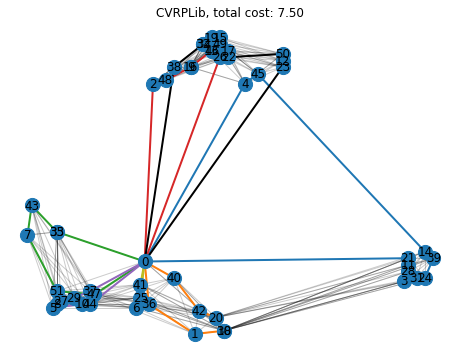

In [186]:
#!g1.1
# G = nx.from_numpy_array(1-test_example['graph'].numpy())
G = nx.from_numpy_array(1-graph.cpu().numpy())
G.remove_edges_from(nx.selfloop_edges(G))
plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos=pos, node_size=200)
nx.draw_networkx_edges(G, pos=pos, alpha=0.2)
subtours = array_separator(test_tour)
colors = ["tab:blue", "tab:red", "tab:green", "tab:purple", "tab:orange", "tab:olive", "black", "tab:blue", "tab:red", "tab:green", "tab:purple", "tab:orange", "tab:olive", "black"]
for n, sub_t in enumerate(subtours):
  nx.draw_networkx_edges(G, pos=pos, width=2, edgelist=np.stack([sub_t[:-1], sub_t[1:]], axis=1).tolist(), edge_color = colors[n])
nx.draw_networkx_labels(G, pos)
dist_matrix = squareform(pdist(x[:, :2].numpy()))
dist_matrix[(range(dist_matrix.shape[0])), (range(dist_matrix.shape[0]))] = np.inf
dist_matrix_ = dist_matrix.copy()
dist_matrix_[(range(dist_matrix_.shape[0])), (range(dist_matrix_.shape[0]))] = 0
cost = dist_matrix_[test_tour[:-1], test_tour[1:]].sum()
plt.title(f'CVRPLib, total cost: {cost:.2f}')
plt.axis('off')
plt.show()


In [187]:
#!g1.1
if cvrplib:
  temp = {i: 0 for i in range(test_df['cars'].max())}
  car = 0
  for i in test_tour[1:].astype(int):
      if i == 0:
          car+=1/2
      else:
          temp[car] += test_df['demand'][i]/test_df['cap'].max()
else:
  temp = {i: 0 for i in range(car_num)}
  car = 0
  for i in test_tour[1:].astype(int):
      if i == 0:
          car+=1/2
      else:
          temp[car] += test_example['demand'][i-1]
temp

{0: 0.9199999999999999,
 1: 1.0,
 2: 0.8700000000000001,
 3: 0.99,
 4: 0.96,
 5: 0.38,
 6: 0.9400000000000001}